In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import load

import clean_utils
from importlib import reload


### Load Data

In [18]:
parcels = pd.read_csv('../data/Blue Sky Code and Inputs/SF_Logistic_Data.csv')

In [3]:
allParcels = gpd.read_file('../data/Parcels   Active and Retired/parcels.shp')

In [4]:
sites = gpd.read_file('../data/site_inventory/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp')

In [5]:
tax = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx')

In [6]:
tax15 = pd.read_excel('../data/tax_assessor/2020.7.10_SF_ASR_Secured_Roll_Data_2015-2016.xlsx')

In [7]:
slopes = gpd.read_file('../data/Slopes of 20% Or Greater/geo_export_2dd8ac56-99a0-4a45-ba46-c85a7407e3e5.shp')

In [8]:
census = gpd.read_file('../data/Census 2000_ Tracts for San Francisco (no water)'
                       '/geo_export_4609700a-c230-4617-92b7-4ef34f23f741.shp')

In [9]:
sfneighborhoods = gpd.read_file('../data/SF Find Neighborhoods/geo_export_2ecdf278-8615-4538-9268-0d4992d30e52.shp')

In [10]:
rent = pd.read_csv('../data/efz/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [11]:
rent = rent[rent.City == 'San Francisco']

In [12]:
rent = rent[['RegionName', '2007-01-31']]

In [13]:
rent = rent[rent.notna().all(axis=1)]

In [14]:
# These codes are the same in both 2007-2008 and 2015-2016
use_codes = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                          sheet_name='Class & Use Code')
neighborhood_codes = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                                   sheet_name='Neigborhood Code')

### Geospatial version of bluesky data

In [15]:
def get_basic_df(cycle):
    if cycle == 4:
        start_year = 2007
    else:
        start_year = 2015
    trainParcels = parcels[(parcels.year >= start_year) & (parcels.year < (start_year + 8))]
    trainY = trainParcels.groupby('MapBlkLot_Master')['Developed'].agg(lambda x: x.ne(0).sum())
    trainX = trainParcels[trainParcels.year == start_year]
    trainDf = pd.merge(trainX.drop('Developed', axis=1), trainY, left_on='MapBlkLot_Master', right_index=True)
    df = clean_utils.transform_bluesky_to_geospatial(trainDf, cycle)
    return df

In [20]:
df4 = get_basic_df(4)

In [21]:
df4.head()

,MapBlkLot_Master,mapblklot,blklot,active,geometry,year,Historic,Residential_Dummy,Zillow_Price_Real,Const_FedReserve_Real,...,zp_DensRestMulti,zp_FormBasedMulti,zp_PDRInd,zp_Public,zp_Redev,zp_RH2,zp_RH3_RM1,Developed,CANTID_blklot_backup,CANTID_geometry_backup
0,0001001,0001001,0001001,T,"POLYGON ((-122.42200 37.80848, -122.42208 37.8...",2007,0,0,93.227099,92.120253,...,0,0,0,1,0,0,0,0,NaN,NaN
1,0002001,0002001,0002001,T,"POLYGON ((-122.42083 37.80863, -122.42086 37.8...",2007,1,0,93.227099,92.120253,...,0,0,0,0,0,0,0,0,NaN,NaN
2,0004002,0004002,0004002,T,"POLYGON ((-122.41570 37.80833, -122.41576 37.8...",2007,0,0,93.227099,92.120253,...,0,0,0,0,0,0,0,0,NaN,NaN
3,0005001,0005001,0005001,T,"POLYGON ((-122.41735 37.80812, -122.41746 37.8...",2007,1,0,93.227099,92.120253,...,0,0,0,0,0,0,0,0,NaN,NaN
4,0006001,0006001,0006001,T,"POLYGON ((-122.41897 37.80791, -122.41915 37.8...",2007,0,0,93.227099,92.120253,...,0,0,0,0,0,0,0,0,NaN,NaN


In [22]:
df5 = get_basic_df(5)

In [23]:
df5.Developed.sum()

88

In [24]:
df4.Developed.sum()

253

#### Get dbi permits from past cycle

In [25]:
pipeline3 = clean_utils.get_pipeline_permits(cycle=3)

In [26]:
pipeline4 = clean_utils.get_pipeline_permits(cycle=4)

### Merge into bluesky data

In [27]:
def merge_pipeline(df, pipeline):
    df = pd.merge(df, pipeline, left_on='blklot', right_index=True, how='left')
    df[pipeline.columns] = df[pipeline.columns].fillna(0)
    return df

In [28]:
df4 = merge_pipeline(df4, pipeline3)

In [29]:
df5 = merge_pipeline(df5, pipeline4)

### Merge Tax Data

In [30]:
full_df4 = clean_utils.merge_tax(df4, tax, cycle=4, parcels=allParcels)

In [31]:
full_df5 = clean_utils.merge_tax(df5, tax15, cycle=5, parcels=allParcels)

In [32]:
full_df5.dtypes[~(full_df4.dtypes == full_df5.dtypes)]

ROOMS       object
STOREYNO    object
FBA         object
dtype: object

In [33]:
full_df5.ROOMS = pd.to_numeric(full_df5.ROOMS, 
                               errors='coerce',
                               downcast='integer')
full_df5.STOREYNO = pd.to_numeric(full_df5.STOREYNO,
                                  errors='coerce',
                                  downcast='integer')
full_df5.FBA = pd.to_numeric(full_df5.FBA, 
                             errors='coerce',
                             downcast='integer')

In [34]:
full_df5 = full_df5[full_df5.FBA.notna() &
                    full_df5.STOREYNO.notna() &
                    full_df5.ROOMS.notna()]

### Feature Engineering

#### Use Codes

In [35]:
use_codes = use_codes[~use_codes.isna().all(axis=1)]

In [36]:
use_codes.head()

,USE,DESC,CLASS,DESC.1
0,SRES,Single Family Residential,CO,Coop Units Unsegregated
1,SRES,Single Family Residential,COS,Coop Units Segregated
2,SRES,Single Family Residential,D,Dwelling
3,SRES,Single Family Residential,DBM,Dwelling BMR
4,SRES,Single Family Residential,LZ,Live/Work Condominium


In [37]:
use_codes = use_codes[use_codes['CLASS'] != 'CLASS']
use_lookup = use_codes.groupby('CLASS')['USE'].agg(list).to_dict()
use_lookup = {k: v[-1] for k, v in use_lookup.items()}

In [38]:
full_df4['general_use_code'] = full_df4.RP1CLACDE.map(use_lookup)
full_df5['general_use_code'] = full_df5.RP1CLACDE.map(use_lookup)

#### New features

In [39]:
full_df4['hasBMR'] = full_df4.RP1CLACDE.str.endswith('BM')
full_df5['hasBMR'] = full_df5.RP1CLACDE.str.endswith('BM')

#### Neighborhood Code

In [40]:
neighborhood_codes.NEIGHBORHOOD = neighborhood_codes.NEIGHBORHOOD.str.strip().str.lower().str.split(' ').str.join('_')

In [41]:
neighborhood_codes.head()

,DISTRICT,CODE,NEIGHBORHOOD,BOUNDRIES
0,1,1A,central_richmond,"South of California, Park Presidio, south of F..."
1,1,1B,inner_richmond,"South of California, Arguello, south of Fulton..."
2,1,1C,jordan_park/laurel_heights,"California, west of Presidio, Geary, Arguello"
3,1,1D,lake_--the_presidio,"West and south of Presidio Terrace, Arguello, ..."
4,1,1E,outer_richmond,"The Ocean, west of 32nd Avenue, south of Fulton"


In [42]:
neighborhoods = {k: v[0] for k, v in neighborhood_codes.groupby('CODE')['NEIGHBORHOOD'].agg(list).to_dict().items()}
neighborhoods = {(k if len(k) == 3 else '0'+k): v for k, v in neighborhoods.items()} 

In [43]:
def lookup_neighborhood(x):
    return neighborhoods.get(x, x)

In [44]:
full_df4['neighborhood'] = full_df4.RP1NBRCDE.apply(lookup_neighborhood)
full_df5['neighborhood'] = full_df5.RP1NBRCDE.apply(lookup_neighborhood)

In [45]:
full_df4 = full_df4.replace({'neighborhood': 
                             {'047': 'west_portal', 
                              '08I': 'union_square', 
                              '09B': 'financial_district_south'}})

In [46]:
districts = {k: v[0] for k, v in neighborhood_codes.groupby('CODE')['DISTRICT'].agg(list).to_dict().items()}
districts = {(k if len(k) == 3 else '0'+k): v for k, v in districts.items()} 

In [47]:
def lookup_district(x):
    return 'district' + str(districts.get(x, x))

In [48]:
full_df4['district'] = full_df4['RP1NBRCDE'].apply(lookup_district)
full_df5['district'] = full_df5['RP1NBRCDE'].apply(lookup_district)

In [49]:
full_df4 = full_df4.drop('RP1NBRCDE', axis=1)
full_df5 = full_df5.drop('RP1NBRCDE', axis=1)

## Slopes, Census Tracts, Rents

<Figure size 640x480 with 0 Axes>

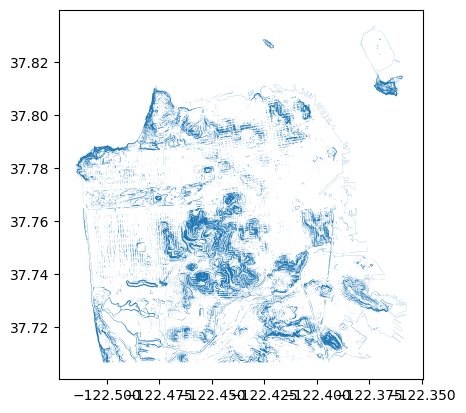

In [50]:
plt.clf()
slopes.plot()
plt.show()

In [51]:
full_df4_slopes = gpd.sjoin(full_df4, slopes[['geometry']], how="left", predicate='within')

In [52]:
full_df4_slopes.index_right.isna().mean().round(2)

0.99

In [53]:
full_df4_slopes2 = gpd.sjoin(full_df4, slopes[['geometry']], how="left", predicate='contains')

In [54]:
full_df4_slopes2.index_right.isna().mean().round(2)

0.97

In [55]:
full_df4_slopes = full_df4_slopes.rename({'index_right': 'steep_lot'}, axis=1)

In [56]:
full_df4_slopes2 = full_df4_slopes2.rename({'index_right': 'steep_lot'}, axis=1)

In [57]:
full_df4_slopes.steep_lot = full_df4_slopes.steep_lot.notna()

In [58]:
full_df4_slopes2.steep_lot = full_df4_slopes2.steep_lot.notna()

In [59]:
full_df4_slopes.steep_lot.mean()

0.014594919192710373

In [60]:
full_df4_slopes2.steep_lot.mean()

0.02778370893750283

In [61]:
full_df4_slopes2[['CANTID_blklot_backup', 'CANTID_geometry_backup']] = full_df4_slopes2[['CANTID_blklot_backup', 
                                                                                         'CANTID_geometry_backup']].astype(str)

In [62]:
full_df4_slopes2 = full_df4_slopes2.drop_duplicates()

In [63]:
full_df4_slopes2.shape

(153204, 68)

<Figure size 640x480 with 0 Axes>

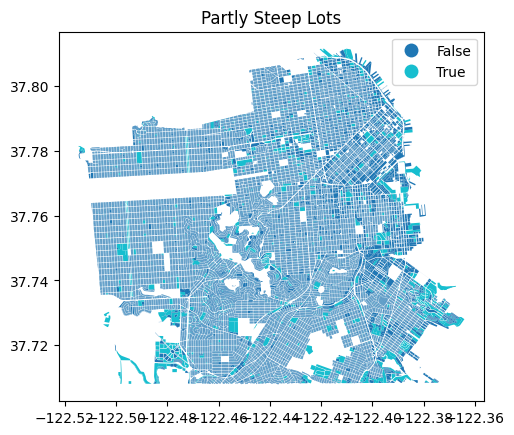

In [64]:
plt.clf()
full_df4_slopes2.plot(column='steep_lot', legend=True)
plt.title('Partly Steep Lots')
plt.show()

In [65]:
full_df4['entirely_steep_lot'] = full_df4_slopes.steep_lot

In [66]:
full_df4['partly_steep_lot'] = full_df4_slopes2.steep_lot

### Census Tracts

In [67]:
census.columns

Index(['age_18_21', 'age_22_29', 'age_30_39', 'age_40_49', 'age_50_64',
       'age_5_17', 'age_65_up', 'age_under5', 'ameri_es', 'asian',
       'ave_fam_sz', 'ave_hh_sz', 'black', 'county', 'families', 'females',
       'fhh_child', 'fipsstco', 'hawn_pi', 'hispanic', 'households',
       'hse_units', 'hsehld_1_f', 'hsehld_1_m', 'males', 'marhh_chd',
       'marhh_no_c', 'med_age', 'med_age_f', 'med_age_m', 'mhh_child',
       'mult_race', 'objectid', 'other', 'owner_occ', 'pop2000', 'renter_occ',
       'rural', 'state', 'stfid', 'tract', 'tractid', 'trt2000', 'urban',
       'vacant', 'white', 'geometry'],
      dtype='object')

In [68]:
full_df4_census = gpd.sjoin_nearest(full_df4.to_crs('EPSG:26910'),
                                    census.to_crs('EPSG:26910'),
                                    how='left')

In [69]:
full_df4_census.shape

(153459, 116)

In [70]:
full_df4_census = full_df4_census.drop_duplicates(subset=['MapBlkLot_Master', 'mapblklot', 'blklot', 'active', 'geometry'])

In [71]:
full_df4_census.shape

(153204, 116)

In [72]:
full_df4_census = full_df4_census.drop('index_right', axis=1)

In [73]:
full_df4 = full_df4_census

### Rents

#### Make Zillow data geospatial for a geospatial join

In [74]:
rent.RegionName = rent.RegionName.str.lower().str.split(' ').str.join('_')

In [75]:
sfneighborhoods.name = sfneighborhoods.name.str.lower().str.split(' ').str.join('_')

In [76]:
rent.RegionName.isin(sfneighborhoods.name).mean()

0.9183673469387755

In [77]:
rent.RegionName[~rent.RegionName.isin(sfneighborhoods.name)].sort_values()

4137                   haight
3508        ingleside_heights
9100        ingleside_terrace
6631                     lake
4513           laurel_heights
1528          marina_district
12166    mount_davidson_manor
7404         north_waterfront
Name: RegionName, dtype: object

In [78]:
sfneighborhoods.name[~sfneighborhoods.name.isin(rent.RegionName)].sort_values()

81                     apparel_city
97         aquatic_park_/_ft._mason
78            candlestick_point_sra
103                       chinatown
18          downtown_/_union_square
58                        fairmount
98                 fishermans_wharf
8                  golden_gate_park
24                   haight_ashbury
75                      india_basin
66               ingleside_terraces
10     laurel_heights_/_jordan_park
6          lincoln_park_/_ft._miley
16                           marina
72                     mclaren_park
64                   merced_heights
26                        mint_hill
33                      mission_bay
67               mt._davidson_manor
76              northern_waterfront
41                       parkmerced
2            presidio_national_park
3                  presidio_terrace
84                   produce_market
32                 showplace_square
35                  treasure_island
34               yerba_buena_island
Name: name, dtype: object

In [79]:
neighborhood_map = {'mount_davidson_manor': 'mt._davidson_manor',
                    'haight': 'haight_ashbury',
                    'ingleside_terrace': 'ingleside_terraces',
                    'laurel_heights': 'laurel_heights_/_jordan_park',
                    'north_waterfront': 'northern_waterfront',
                    'marina_district': 'marina',
                    'ingleside_heights': 'merced_heights',
                    'lake': 'parkmerced'}

In [80]:
assert all([k in sfneighborhoods.name.values.tolist() for k in neighborhood_map.values()])
assert all([k in rent.RegionName.values.tolist() for k in neighborhood_map.keys()])

In [81]:
rent = rent.replace({'RegionName': neighborhood_map})

In [82]:
sfneighborhoods.replace({'name': {'downtown_/_union_square': 'downtown'}})

,link,name,geometry
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",seacliff,"POLYGON ((-122.49346 37.78352, -122.49373 37.7..."
1,NaN,lake_street,"POLYGON ((-122.48715 37.78379, -122.48729 37.7..."
2,http://www.nps.gov/prsf/index.htm,presidio_national_park,"POLYGON ((-122.47758 37.81099, -122.47712 37.8..."
3,NaN,presidio_terrace,"POLYGON ((-122.47241 37.78735, -122.47100 37.7..."
4,http://www.sfgate.com/neighborhoods/sf/innerri...,inner_richmond,"POLYGON ((-122.47263 37.78631, -122.46683 37.7..."
...,...,...,...
112,"http://en.wikipedia.org/wiki/Corona_Heights,_S...",corona_heights,"POLYGON ((-122.43519 37.76267, -122.43532 37.7..."
113,http://en.wikipedia.org/wiki/Haight-Ashbury,ashbury_heights,"POLYGON ((-122.45196 37.76148, -122.45210 37.7..."
114,"http://en.wikipedia.org/wiki/Eureka_Valley,_Sa...",eureka_valley,"POLYGON ((-122.43734 37.76235, -122.43704 37.7..."
115,"http://en.wikipedia.org/wiki/St._Francis_Wood,...",st._francis_wood,"POLYGON ((-122.47157 37.73471, -122.46831 37.7..."


In [83]:
rent.RegionName[~rent.RegionName.isin(sfneighborhoods.name)].sort_values()

Series([], Name: RegionName, dtype: object)

In [84]:
sfneighborhoods.name[~sfneighborhoods.name.isin(rent.RegionName)].sort_values()

81                 apparel_city
97     aquatic_park_/_ft._mason
78        candlestick_point_sra
103                   chinatown
18      downtown_/_union_square
58                    fairmount
98             fishermans_wharf
8              golden_gate_park
75                  india_basin
6      lincoln_park_/_ft._miley
72                 mclaren_park
26                    mint_hill
33                  mission_bay
2        presidio_national_park
3              presidio_terrace
84               produce_market
32             showplace_square
35              treasure_island
34           yerba_buena_island
Name: name, dtype: object

In [85]:
sfneighborhoods[sfneighborhoods.name.str.contains('down')]

,link,name,geometry
18,http://www.sfgate.com/neighborhoods/sf/unionsq...,downtown_/_union_square,"POLYGON ((-122.40238 37.79097, -122.40196 37.7..."


In [86]:
full_df4.neighborhood[full_df4.neighborhood.notna() & full_df4.neighborhood.str.contains('down')]

Series([], Name: neighborhood, dtype: object)

<Figure size 640x480 with 0 Axes>

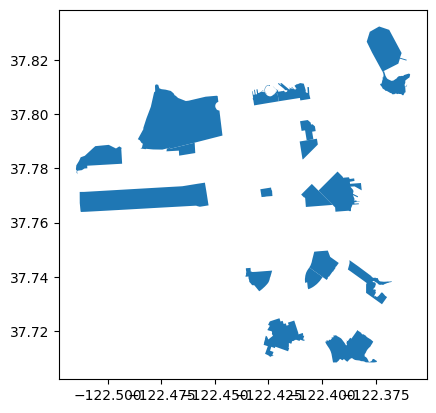

In [87]:
plt.clf()
sfneighborhoods[~sfneighborhoods.name.isin(rent.RegionName)].plot()
plt.show()

In [88]:
neighborhoods_rent = pd.merge(sfneighborhoods, rent, left_on='name', right_on='RegionName', how='right')

<Figure size 640x480 with 0 Axes>

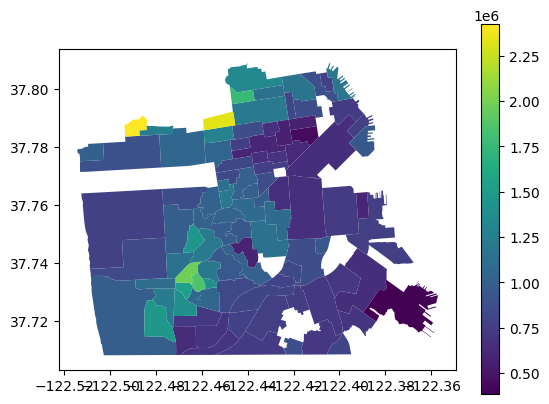

In [89]:
plt.clf()
neighborhoods_rent.plot(column='2007-01-31', legend=True)
plt.show()

In [90]:
neighborhoods_rent = neighborhoods_rent.drop(['link', 'RegionName'], axis=1)

In [91]:
neighborhoods_rent = neighborhoods_rent.rename({'name': 'neighborhood', '2007-01-31': 'rentJan07'}, axis=1)

In [92]:
full_df4 = full_df4.replace({'neighborhood': {'dowtown': 'downtown',
                                             'croker_amazon': 'crocker_amazon',
                                             'ingleside_terrace': 'ingleside_terraces',
                                             'sea_cliff': 'seacliff',
                                             'lake_shore': 'lakeshore'}})

In [93]:
full_df4_rent = gpd.sjoin(full_df4,
                          neighborhoods_rent.drop('neighborhood', axis=1).to_crs('EPSG:26910'),
                          how='left',
                          predicate='within')

In [94]:
full_df4_rent.shape[0] == full_df4.shape[0]

True

In [95]:
full_df4_rent

,MapBlkLot_Master,mapblklot,blklot,active,geometry,year,Historic,Residential_Dummy,Zillow_Price_Real,Const_FedReserve_Real,...,state,stfid,tract,tractid,trt2000,urban,vacant,white,index_right,rentJan07
0,0001001,0001001,0001001,T,"POLYGON ((550878.453 4184723.158, 550871.829 4...",2007,0,0,93.227099,92.120253,...,06,06075010200,010200,102,010200,0.0,277.0,3710.0,NaN,NaN
1,0002001,0002001,0002001,T,"POLYGON ((550982.008 4184740.595, 550979.069 4...",2007,1,0,93.227099,92.120253,...,06,06075010200,010200,102,010200,0.0,277.0,3710.0,NaN,NaN
2,0004002,0004002,0004002,T,"POLYGON ((551433.330 4184709.650, 551427.878 4...",2007,0,0,93.227099,92.120253,...,06,06075010100,010100,101,010100,0.0,184.0,1771.0,NaN,NaN
3,0005001,0005001,0005001,T,"POLYGON ((551288.628 4184685.876, 551278.486 4...",2007,1,0,93.227099,92.120253,...,06,06075010100,010100,101,010100,0.0,184.0,1771.0,NaN,NaN
4,0006001,0006001,0006001,T,"POLYGON ((551145.469 4184661.289, 551129.737 4...",2007,0,0,93.227099,92.120253,...,06,06075010100,010100,101,010100,0.0,184.0,1771.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153209,VACSTART2,VACSTART2,VACSTART2,T,"POLYGON ((554444.751 4177478.627, 554344.276 4...",2007,0,0,93.227099,92.120253,...,06,06075060900,060900,609,060900,0.0,3.0,199.0,NaN,NaN
153210,VACSTBER,VACSTBER,VACSTBER,T,"POLYGON ((551422.340 4177345.184, 551423.119 4...",2007,0,0,93.227099,92.120253,...,06,06075025200,025200,252,025200,0.0,55.0,3390.0,9.0,863378.717414
153211,VACSTHES1,VACSTHES1,VACSTHES1,T,"POLYGON ((552907.975 4174207.814, 552908.418 4...",2007,1,0,93.227099,92.120253,...,06,06075061000,061000,610,061000,0.0,23.0,378.0,89.0,804107.718649
153215,VACSTMIN,VACSTMIN,VACSTMIN,T,"POLYGON ((552400.856 4181906.731, 552399.775 4...",2007,0,0,93.227099,92.120253,...,06,06075017601,017601,176.01,017601,0.0,119.0,2044.0,2.0,652143.889289


In [96]:
full_df4_rent = full_df4_rent.drop('index_right', axis=1)

In [97]:
neighborhood_map_from_fdf_to_zillow = {'central_sunset': 'outer_sunset',
                                       'central_richmond': 'outer_richmond',
                                       'inner_parkside': 'parkside',
                                       'outer_parkside': 'parkside',
                                       'bayview_heights': 'bayview',
                                       'buena_vista_park': 'buena_vista'}

In [98]:
rent = rent.replace(
    {'RegionName' : {
        'buena_vista_park': 'buena_vista',
        'laurel_heights': 'jordan_park/laurel_heights', 
        'eureka_valley': 'eureka_valley/dolores_heights',
        'financial_district': 'financial_district_north',
        'lake_--the_presidio': 'presidio',
        'haight': 'haight_ashbury',
        'civic_center': 'van_ness/_civic_center',
        'marina_district': 'marina',
        'parnassus_heights': 'parnassus/ashbury_heights',
        'laguna_honda': 'forest_hill_extension',
        'mt._davidson_manor': 'mount_davidson_manor'
    }}
)

In [99]:
opensf_neighborhoods = full_df4.neighborhood[~full_df4.neighborhood.isin(rent.RegionName)].unique()
opensf_neighborhoods = [str(a) for a in opensf_neighborhoods.tolist()]
opensf_neighborhoods.sort()
opensf_neighborhoods

['bayview_heights',
 'buena_vista_park',
 'central_richmond',
 'central_sunset',
 'downtown',
 'financial_district_south',
 'ingleside_heights',
 'inner_ission',
 'inner_parkside',
 'jordan_park/laurel_heights',
 'lake_--the_presidio',
 'lakeside',
 'mission_bay',
 'nan',
 'north_waterfront',
 'outer_parkside',
 'park_north',
 'pine_lake_park',
 'twin_peaks',
 'union_square',
 'yerba_buena']

In [100]:
full_df4_rent2 = full_df4.merge(rent.add_prefix('rent_'), left_on='neighborhood', right_on='rent_RegionName', how='left')

In [101]:
full_df4_rent2['rent_2007-01-31'].isna().mean()

0.2519777551499961

In [102]:
full_df4_rent.rentJan07 = full_df4_rent.rentJan07.fillna(full_df4_rent2['rent_2007-01-31'])

In [103]:
full_df4_rent.rentJan07.notna().mean()

0.992265215007441

In [104]:
full_df4_rent[full_df4_rent['rentJan07'].isna()].neighborhood.value_counts()

lake_--the_presidio         426
union_square                283
mission_bay                 204
north_waterfront            139
yerba_buena                  38
bayview_heights              28
inner_ission                 15
downtown                      7
outer_parkside                4
ingleside_heights             4
mission_dolores               4
twin_peaks                    3
hunters_point                 3
bayview                       3
russian_hill                  1
financial_district_north      1
presidio_heights              1
outer_richmond                1
bernal_heights                1
Name: neighborhood, dtype: int64

In [105]:
full_df4_rent3 = gpd.sjoin_nearest(full_df4.to_crs('EPSG:26910'),
                                   neighborhoods_rent.drop('neighborhood', axis=1).to_crs('EPSG:26910'),
                                   how='left')

In [106]:
full_df4_rent3 = full_df4_rent3.drop('index_right', axis=1)

In [107]:
full_df4_rent3[['CANTID_blklot_backup', 'CANTID_geometry_backup']] = full_df4_rent3[['CANTID_blklot_backup', 
                                                                                     'CANTID_geometry_backup']].astype(str)

In [108]:
full_df4_rent3 = full_df4_rent3.drop_duplicates(subset=['MapBlkLot_Master',
                                                        'mapblklot', 
                                                        'blklot', 
                                                        'geometry'])

In [109]:
full_df4_rent.rentJan07 = full_df4_rent.rentJan07.fillna(full_df4_rent3['rentJan07'])

In [110]:
full_df4_rent.rentJan07.notna().mean()

0.9999412547975248

In [111]:
full_df4 = full_df4_rent

<Figure size 640x480 with 0 Axes>

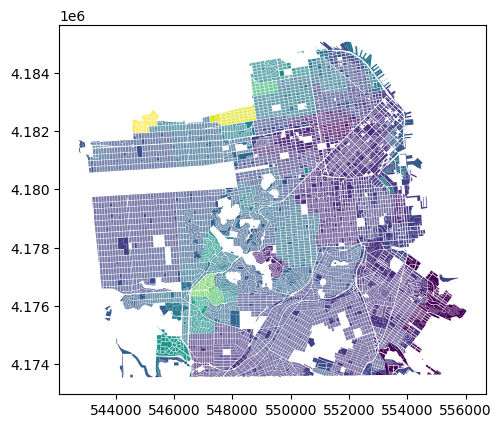

In [112]:
plt.clf()
full_df4.plot(column='rentJan07')
plt.show()

### Treat inclusion in site inventory as a feature

In [113]:
full_df4 = clean_utils.get_site_inventory_feature(full_df4, sites, cycle=4)
full_df5 = clean_utils.get_site_inventory_feature(full_df5, sites, cycle=4)

### Drop constant columns

In [114]:
full_df4 = full_df4.drop([c for c in full_df4.columns if 'CANTID' in c], axis=1)
full_df5 = full_df5.drop([c for c in full_df5.columns if 'CANTID' in c], axis=1)

In [115]:
full_df4 = full_df4.drop(full_df4.columns[full_df4.nunique() <= 1], axis=1)
full_df5 = full_df5.drop(full_df5.columns[full_df5.nunique() <= 1], axis=1)

In [124]:
full_df4 = full_df4.drop(['geometry', 'blklot', 'mapblklot', 'active', 'PROPLOC', 'RP1PRCLID'], axis=1)

In [125]:
full_df5 = full_df5.drop(['geometry', 'blklot', 'mapblklot', 'active', 'PROPLOC', 'RP1PRCLID'], axis=1)

In [126]:
full_df4.to_csv('cleaned_rhna4_data.csv', index=False)
full_df5.to_csv('cleaned_rhna5_data.csv', index=False)